In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import textcomparisons as tc
from collections import Counter
import random

data_folder = "data"
spotify_file = "spotify_articles.csv"
spotify_path = os.path.join(data_folder, spotify_file)

census_file = "census_articles.csv"
census_path = os.path.join(data_folder, census_file)

helsinki_file = "helsinki_articles.csv"
helsinki_path = os.path.join(data_folder, helsinki_file)

In [2]:
def cleanArticle(article):
    paras = article.split("###")
    paras = [para for para in paras if len(para.split()) > 4]
    return("\n".join(paras))

def readArticles(path):
    """ Reads df of articles from the given path, 
    and adds clean text versions to df before returning """
    article_df = pd.read_csv(path)
    # article_df["clean_text"] = [cleanArticle(text) for text in article_df["text"]]
    return article_df

spotify_df = readArticles(spotify_path)
census_df = readArticles(census_path)
helsinki_df = readArticles(helsinki_path)

# print(Counter(spotify_df["publisher"]))
# print(Counter(helsinki_df["publisher"]))
# print(Counter(census_df["publisher"]))
helsinki_df.head()

,id,publisher,scrape_time,text
0,6,nytimes.com,2018-07-15T07:54:28-04:00,Trump Plays Golf in Scotland Before Putin Summ...
1,35,dailymail.co.uk,2018-07-15T06:34:13-04:00,"Sunday, Jul 15th 2018 5-Day Forecast ### Adver..."
2,57,newyorker.com,2018-07-16T09:10:56-04:00,Will Putin Spare Trump the Lecture He Has Give...
3,77,oregonlive.com,2018-07-16T10:19:40-04:00,Enter City and State or Zip Code ### Congratul...
4,106,bostonglobe.com,2018-07-16T03:33:28-04:00,The Boston Globe ### Scroll to top of page ###...


In [3]:
clust_levinson = [610, 3581, 6678]
clust_reuters = [761, 16223]
clust_ap = [8200, 8818, 9990]
clust_ap_files = [12769, 2313, 6190]
clust_freshair = [7042, 6644]
unique = [6754, 10053, 10250, 6146, 967, 15307, 15482, 604, 1766, 4738, 5906, 6844, 14721, 14730]
clust_wrong = [10254, 9090]
# 7624 = paraphrase of AP
# 8985 = briefing of many news stories, includes snippet from 6844
clust_snippet = [7624, 8985, 5289]

# 967 = not exactly copied from, but heavily based off of the original NYT report 
# 1766 = heavily based off of reuters 

In [4]:
doc_r1 = tc.Document(census_df[census_df["id"] == 761].iloc[0, 3], clean = False)
doc_ap1 = tc.Document(census_df[census_df["id"] == 8200].iloc[0, 3], clean = False)
doc_ap2 = tc.Document(census_df[census_df["id"] == 8818].iloc[0, 3], clean = False)
doc_w = tc.Document(census_df[census_df["id"] == 10254].iloc[0, 3], clean = False)

doc_6844 = tc.Document(census_df[census_df["id"] == 6844].iloc[0, 3], clean = False)
snip_6844 = tc.Document(census_df[census_df["id"] == 8985].iloc[0, 3], clean = False)

In [5]:
comparer = tc.DocumentComparisons()
jac_mat_ap = comparer.jaccard_matrix(doc_ap1, doc_ap2)
jac_mat_w = comparer.jaccard_matrix(doc_ap1, doc_w)

def display_mat(jacmat, normalize = False, xlabs = None, ylabs = None):
    fig = plt.figure(figsize = (20, 20))
    ax = fig.add_subplot(111)
    if normalize:
        ax.matshow(jacmat, cmap = plt.cm.Blues)
    else:
        ax.matshow(jacmat, cmap = plt.cm.Blues, vmin = 0, vmax = 1)
    for i in range(jacmat.shape[0]):
        for j in range(jacmat.shape[1]):
            ax.text(j, i, round(jacmat[i, j], 2), va = "center", ha = "center")
    ax.set_xticks([x for x in range(-1, jacmat.shape[1] + 1)])
    ax.set_yticks([x for x in range(-1, jacmat.shape[0] + 1)])
    if xlabs is not None:
        ax.set_xticklabels([''] + xlabs)
        plt.xticks(rotation = 90)
    if ylabs is not None:
        ax.set_yticklabels([''] + ylabs)

#display_mat(jac_mat_ap)
#display_mat(jac_mat_w)

In [6]:
# jac_mat_ap_r = comparer.jaccard_matrix(doc_r1, doc_ap1)
print("Example of a 0.4 Jaccard index:\n")
print(doc_r1.get_sentences()[1], "\n", doc_ap1.get_sentences()[4])

Example of a 0.4 Jaccard index:

 In a filing in Manhattan federal court on Thursday, the groups said that the administration hid the fact during the course of the lawsuit that went to trial last year that Thomas Hofeller, a longtime Republican specialist on drawing electoral districts, played a "significant role" in planning the citizenship question. 
  The filing in Manhattan federal court said a trove of newly discovered documents revealed that Thomas Hofeller, a longtime Republican gerrymandering guru, played a key role in pushing the Trump administration to include a citizenship question on the census for the first time since 1950.


In [7]:
jac_mat_snip = comparer.jaccard_matrix(doc_6844, snip_6844)
#display_mat(jac_mat_snip)

match_mat_snip = comparer.match_matrix(doc_6844, snip_6844)
#display_mat(match_mat_snip)
comparer.print_sentence_matches()

S 0 :  Immigration activists rallied outside the Supreme Court in April as the justices heard arguments over the Trump administration's plan to ask about citizenship on the 2020 census.(J. 

	T 54 0.84 :  Immigration activists rally outside the Supreme Court as the justices hear arguments over the Trump administration's plan to ask about citizenship on the 2020 census, in Washington. 

S 2 :  WASHINGTON — Just weeks before the Supreme Court is expected to rule on whether the Trump administration can add a citizenship question to the 2020 census, new evidence emerged Thursday suggesting that the question was crafted specifically to give an electoral advantage to white Republicans. 

	T 57 0.72 :  BOMBSHELL DEVELOPMENT IN CENSUS CASE: "Just weeks before the Supreme Court is expected to rule on whether the Trump administration can add a citizenship question to the 2020 Census, new evidence emerged Thursday suggesting the question was crafted specifically to give an electoral advantage to 

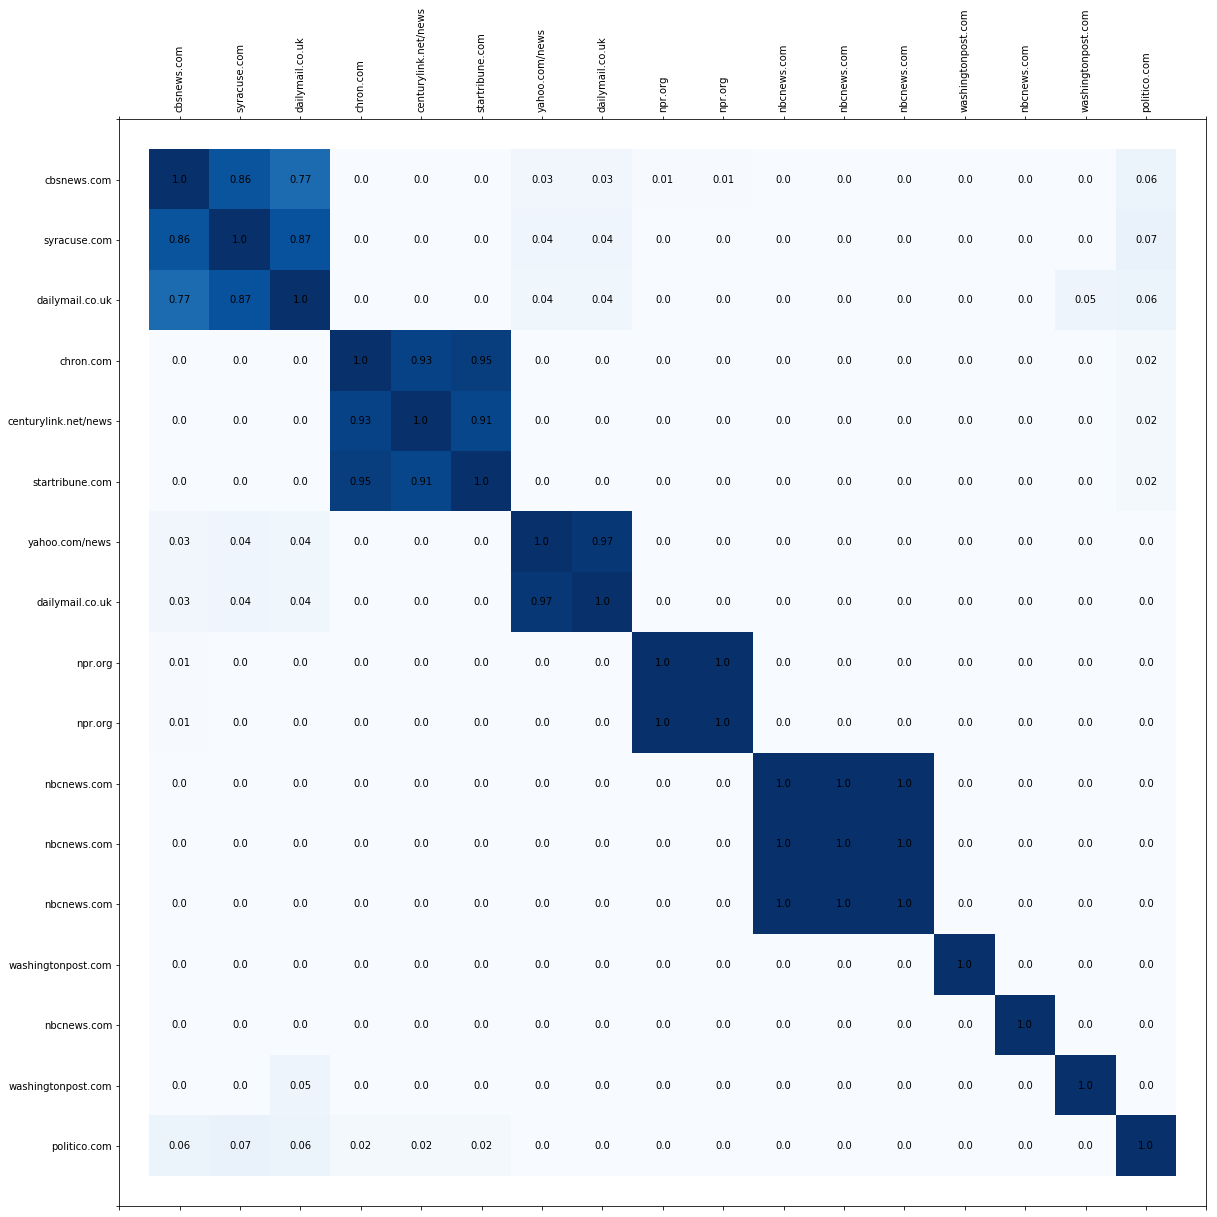

In [8]:
matcher = tc.ArticleComparisons()
clusters_dict = {}
docs_list = clust_ap + clust_ap_files + clust_reuters + clust_freshair + clust_levinson + clust_wrong + [8985, 1766]
# 8985 = briefing of many news stories, includes snippet from 6844
# 1766 = heavily based off of reuters 
for doc_id in docs_list:
    doc = tc.Document(census_df[census_df["id"] == doc_id].iloc[0, 3], clean = False)
    clusters_dict[doc_id] = doc

score_mat = matcher.jac_score_mat(clusters_dict, weighted = False)
axislabels = [census_df[census_df["id"] == id].iloc[0, 1] for id in docs_list]
display_mat(score_mat, True, axislabels, axislabels)

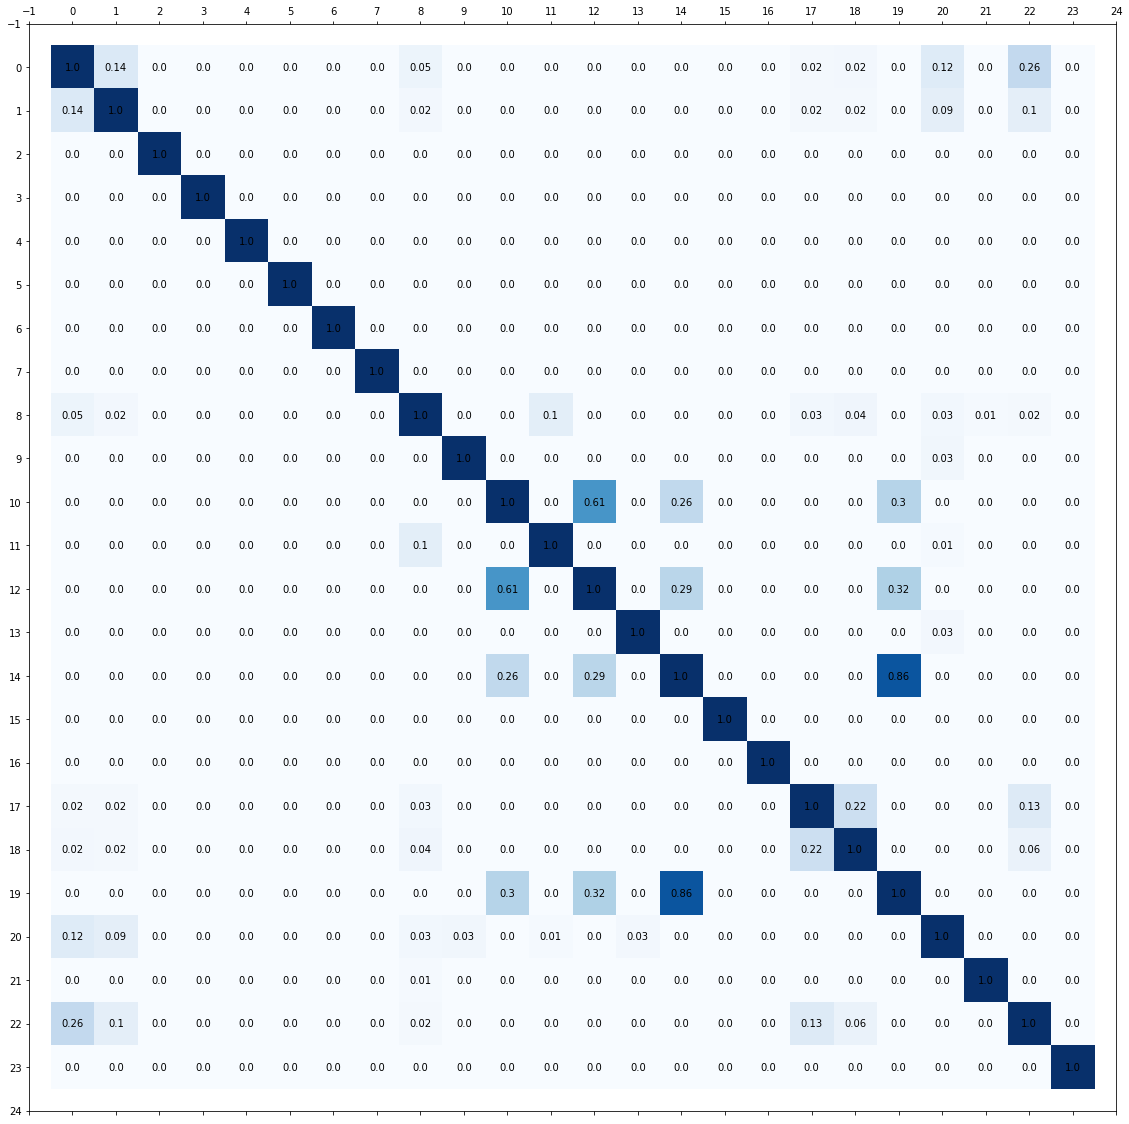

In [9]:
dm_dict = {}
dm_df = helsinki_df[(helsinki_df["publisher"] == "dailymail.co.uk")]
for doc_id in dm_df["id"]:
    dm_dict[doc_id] = tc.Document(helsinki_df[helsinki_df["id"] == doc_id].iloc[0, 3], clean = False)
    

score_mat = matcher.jac_score_mat(dm_dict, weighted = False)
display_mat(score_mat, True)

In [10]:
for (i, doc) in dm_dict.items():
    print(i, "\n")
    print(doc, "\n\n")

35 

Sunday, Jul 15th 2018 5-Day Forecast 
 Summit fever: Trump reaches for big moment with Putin 
 HELSINKI (AP) - A face-to-face sitdown with a long-feared foe. Endless media hype. Huge ratings. 
 Although President Donald Trump has met with Russia's Vladimir Putin twice before, he is eager to recreate in Finland the heady experience that he had last month with North Korean leader Kim Jong Un in Singapore: a summit that became a mass media event complete with powerful presidential images. Ever the showman and insistent on establishing closer ties to Moscow, Trump overruled his advisers and demanded the rituals and pageantry of a formal summit. 
 Trump had boasted to confidants about the number of cameras in Singapore, claiming it dwarfed coverage of the Oscars, according to a person familiar with his thinking but not authorized to discuss private conversations and so spoke on condition of anonymity. Though Trump originally expressed concern that Helsinki was not glamorous enough and 

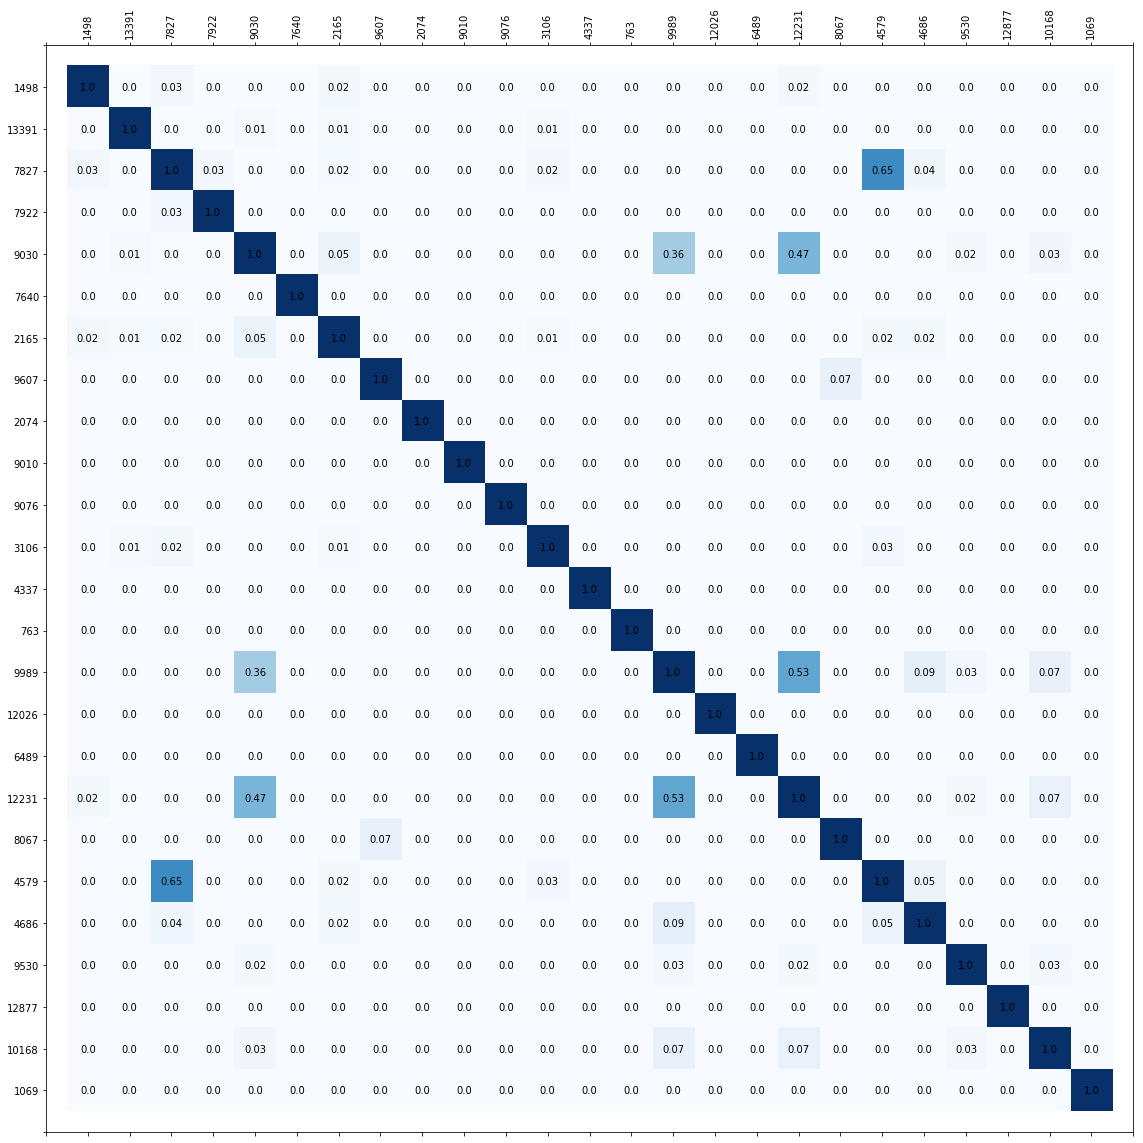

In [11]:
#rand_ids = random.sample(list(helsinki_df["id"]), 25)
rand_ids = [1498, 13391, 7827, 7922, 9030, 7640, 2165, 9607, 2074, 9010, 9076, 3106, 4337, 763, 9989, 12026, 6489, 12231, 
           8067, 4579, 4686, 9530, 12877, 10168, 1069]
helsinki_dict = {}
for doc_id in rand_ids:
    helsinki_dict[doc_id] = tc.Document(helsinki_df[helsinki_df["id"] == doc_id].iloc[0, 3], clean = False)

score_mat = matcher.jac_score_mat(helsinki_dict, weighted = False)
axislabels = list(helsinki_dict.keys())
display_mat(score_mat, True, axislabels, axislabels)

# articles 7827, 4579 only have an index of 0.63, but are the same article with the exception of an additional few paras
# reason: garbage text (HTML) in 7827, repeated text (esp. photo captions and quotes)
# CHANGED: deleted the constraint that sentences can only match adjacent sentences, now up to 0.65

# articles 9030, 9989, 12231 have scores in the .30s-.50
# All share copied paragraphs, but also different follow-up paragraphs 

# articles 9989, 4686

# article 4686 (0.57), 2074 (0.71) get low scores with itself...
# FIXED: deleted constraint for adjacent sentences 

In [12]:
'''
for (i, doc) in helsinki_dict.items():
    print(i, "\n")
    print(doc, "\n\n")
'''

'\nfor (i, doc) in helsinki_dict.items():\n    print(i, "\n")\n    print(doc, "\n\n")\n'

In [13]:
#[helsinki_df[helsinki_df["id"] == id].iloc[0, 1] for id in rand_ids]

S 17 :  Pablo Martinez Monsivais / AP 

	T 10 0.8 : (AP Photo/Pablo Martinez Monsivais) 

S 18 :  U.S. President Donald Trump and first lady Melania Trump arrive at the airport in Helsinki, Finland, on July 15, 2018, on the eve of his meeting with Russian President Vladimir Putin. 

	T 12 0.94 :  U.S. President Donald Trump and first lady Melania Trump arrive at the airport in Helsinki, Finland, Sunday, July 15, 2018 on the eve of his meeting with Russian President Vladimir Putin. 



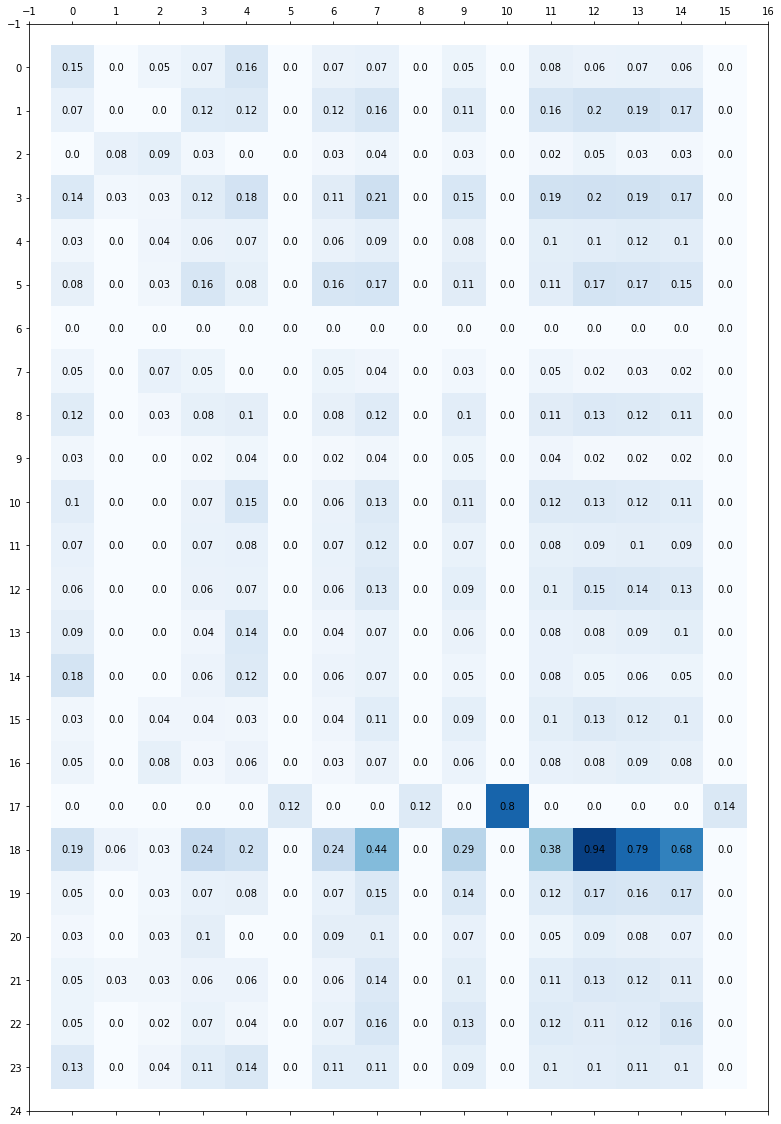

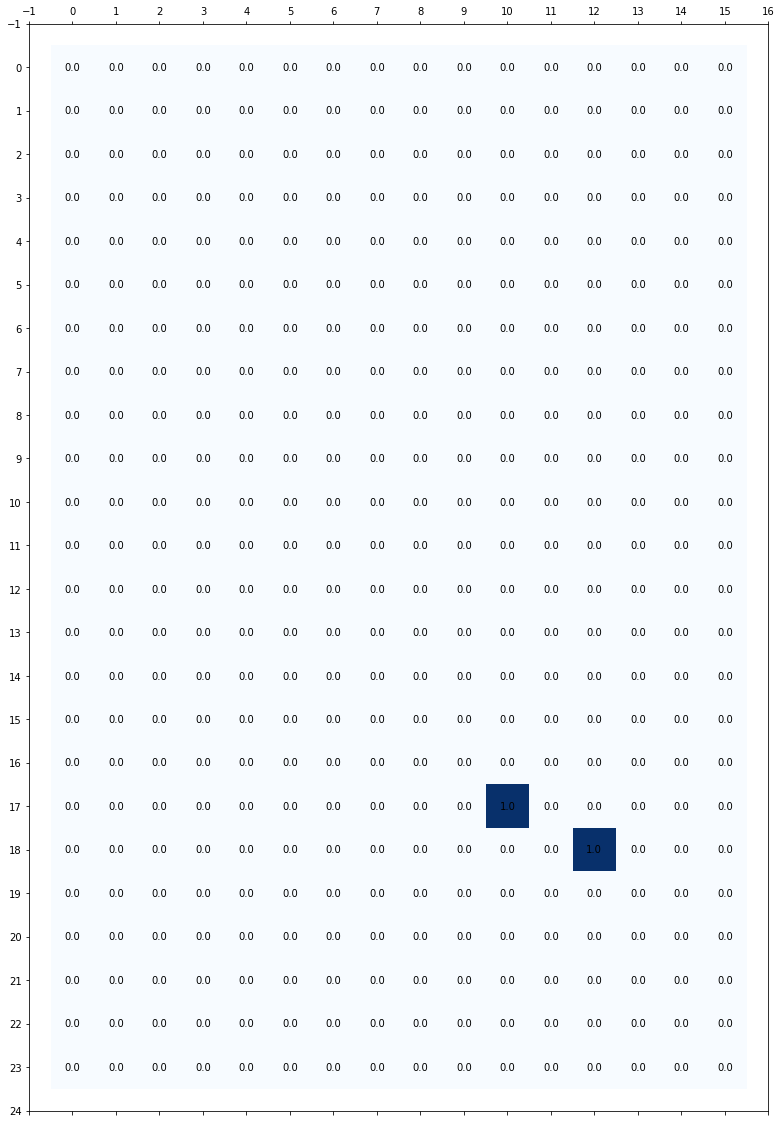

In [14]:
id1 = 9989
id2 = 4686
jacmat = comparer.jaccard_matrix(helsinki_dict[id1], helsinki_dict[id2])
display_mat(jacmat)

matchmat = comparer.match_matrix()
display_mat(matchmat)

comparer.print_sentence_matches()

In [17]:
bow1 = helsinki_dict[id1].get_bow_sentences()[17]
bow2 = helsinki_dict[id2].get_bow_sentences()[10]
comparer.jaccard_index(bow1, bow2)
print(set(bow1) & set(bow2))
set(bow1) - set(bow2), set(bow2) - set(bow1)

{'monsivai', 'AP', 'pablo', 'martinez'}


(set(), {'photo'})

In [16]:
helsinki_dict[id1].get_sentences()[19],helsinki_dict[id1].get_sentences()[17]

(' The summit began just hours after Trump blamed the United States — and not Russian election meddling or its annexation of Crimea — for a low-point in U.S.-Russia relations.',
 ' Pablo Martinez Monsivais / AP')